# Careers in gear
## Predict hire / nohire from lead_details.csv

### MLP model, no hidden layers so "LR",  with embedded category vectors


In [1]:
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('ERROR')

import shutil
import pathlib
import pickle
import itertools

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

# from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score
)
# from sklearn import linear_model

from tensorflow.keras import models, layers

# from feature_utils import CategoricalEncoder, DataFrameSelector

from pp_pipeline_utils import (
    splitx,
    DataFrameSelector,
    CategoricalEncoder
)

from metric_utils import (
    plot_precision_recall,
    plot_roc,
    plot_precision_vs_score,
    precision_at_score_percentile,
    precision_by_score_buckets,
    plot_precision_by_score_buckets,
    plot_bucket_counts
)

# from score2ppv import score2ppv, score2ppv_model

In [2]:
np.random.seed(42)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("Set2", 10))

In [4]:
features_file = 'data/cig_features.parq'

In [5]:
features = pd.read_parquet(features_file)

In [6]:
features.sample(5).T

,4522,2499,1413,4357,3830
lead_id,9055365,9337921,1660939,13010742,10484415
form_data_id,438970,454948,230119,1134721,672895
lead_match_client_id,5815,5709,10,11,5817
structured_campaign_name,Martin Resource Management : Regional (Martin ...,Trans System Inc : System Transport Pacific No...,US Xpress : Dedicated : p5 : a13 : M_1140093 (R),K and B Transportation Inc. : otr (OTR 4) : PM...,Ozark : Company Driver : PMC p5 : a1 : M_11350...
company_nicename,Martin Resource Management,System Transport,US Xpress,K&B Transportation,"Ozark Motor Lines, Inc"
full_name,Curtis Hale,Danny Malone,Louis Hubbard,ROBERT TOBAR,Joel Bishop
hired,0,0,1,1,1
city,Longview,Long Beach,Montgomery,Covington,Flat Rock
state,TX,CA,AL,TN,NC
zip,75604,90804,36106,38019,28731


In [7]:
features.hired.sum()

1558

In [8]:
features.hired.sum() / len(features)

0.30471347545472327

In [9]:
def ordinal_keys(s):
    sset = set(s)
    sset.add('')
    return sorted(sset)

In [10]:
category_keys = [
    'driver_type',
    'climate_region'
]

for ck in category_keys:
    features[ck] = features[ck].fillna('')

category_values = {x: ordinal_keys(features[x].unique()) for x in category_keys}
category_lookup = {x:x for x in category_keys}

def get_cat_vals(cat):
    return category_values[category_lookup[cat]]

def make_cat_encoder(atts, encoding='onehot', handle_unknown='ignore'):
    return CategoricalEncoder(encoding=encoding,
                              categories=[get_cat_vals(x) for x in atts],
                              handle_unknown=handle_unknown)

In [11]:
numeric_atts = [
    'exp_yr_num',
    'tickets',
    # rest are boolean
    
    'lease_purchase',
    'drivers_license_class_a',
    'hazmat',
    'tanker',
    'doublestriples',
    'job_alerts',
    'sms_alerts_opt_in',
    'came_from_suggested_job',
    'run_single',
    'run_team',
    'flatbed',
    'van',
    'reefer',
    'multi',
    'oversized',
    'stepdeck',
    'heavy_haul',
    'haul_tanker',
]

category_atts = [
    'driver_type',
    'climate_region'
]

In [12]:
train_set, test_set = train_test_split(features.copy(), test_size=0.2)
len(train_set), len(test_set)

(4090, 1023)

In [13]:
splitx_ft = FunctionTransformer(splitx, validate=True, kw_args={'numlen': len(numeric_atts)})

In [14]:
num_pipeline = Pipeline([
    ('num_selector', DataFrameSelector(numeric_atts)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_selector', DataFrameSelector(category_atts)),
    ('ordinal_encoder', make_cat_encoder(category_atts, encoding='ordinal', handle_unknown='error'))
])

fu_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

pipeline = Pipeline([
    ('fu_pipeline', fu_pipeline),
    ('splitx_ft', splitx_ft)
])

In [15]:
%%time
pipeline.fit(train_set)

CPU times: user 13.1 ms, sys: 152 µs, total: 13.2 ms
Wall time: 12.3 ms


Pipeline(memory=None,
         steps=[('fu_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('num_selector',
                                                                  DataFrameSelector(attribute_names=['exp_yr_num',
                                                                                                     'tickets',
                                                                                                     'lease_purchase',
                                                                                                     'drivers_license_class_a',
                                                                                                     'hazmat',
                                                                                                    

In [16]:
X_train = pipeline.transform(train_set)
y_train = train_set.hired

In [17]:
X_test = pipeline.transform(test_set)
y_test = test_set.hired

In [18]:
inputs = []
base_layers = []
embedclasses = {}

numeric_count = len(numeric_atts)
inp = layers.Input(shape=(numeric_count,))
inputs.append(inp)
numeric_layer = layers.Dense(numeric_count, name='numeric_input')(inp)
base_layers.append(numeric_layer)

for catname in category_atts:
    m = len(get_cat_vals(catname))
    n = min((m + 1) // 2, 50)
    embedname = category_lookup[catname]
    if embedname in embedclasses:
        embedclass = embedclasses[embedname]
    else:
        embedclass = layers.Embedding(m, n, input_length=1, name=(embedname + '_embedding'))
        embedclasses[embedname] = embedclass
    inp = layers.Input(shape=(1,))
    inputs.append(inp)
    emb = embedclass(inp)
    emb_reshaped = layers.Reshape(target_shape=(n,))(emb)
    base_layers.append(emb_reshaped)

In [19]:
len(X_train)

3

In [20]:
[x.shape for x in X_train]

[(4090, 20), (4090,), (4090,)]

In [21]:
x = layers.Concatenate()(base_layers)
# x = layers.Dense(16, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [22]:
%%time
history = model.fit(X_train, y_train, batch_size=1024, epochs=40,
          class_weight=compute_class_weight('balanced', [0,1], y_train)
         )

Epoch 1/40
4090/4090 [==============================] - 1s 211us/sample - loss: 0.7523
Epoch 2/40
4090/4090 [==============================] - 0s 5us/sample - loss: 0.7090
Epoch 3/40
4090/4090 [==============================] - 0s 4us/sample - loss: 0.6831
Epoch 4/40
4090/4090 [==============================] - 0s 5us/sample - loss: 0.6632
Epoch 5/40
4090/4090 [==============================] - 0s 4us/sample - loss: 0.6465
Epoch 6/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6322
Epoch 7/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.6192
Epoch 8/40
4090/4090 [==============================] - 0s 4us/sample - loss: 0.6077
Epoch 9/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.5971
Epoch 10/40
4090/4090 [==============================] - 0s 3us/sample - loss: 0.5876
Epoch 11/40
4090/4090 [==============================] - 0s 4us/sample - loss: 0.5789
Epoch 12/40
4090/4090 [==============================] - 0s 3

In [23]:
y_score = model.predict(X_test)

In [24]:
roc_auc_score(y_test, y_score)

0.8128042843232717

In [25]:
average_precision_score(y_test, y_score)

0.6730782381147841

In [26]:
precision_at_score_percentile(y_test, y_score, 90)

0.7961165048543689

In [27]:
precision_at_score_percentile(y_test, y_score, 99)

0.7272727272727273

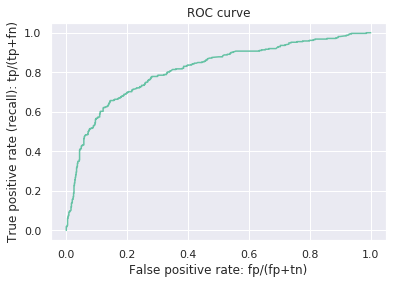

In [28]:
plot_roc(y_test, y_score)

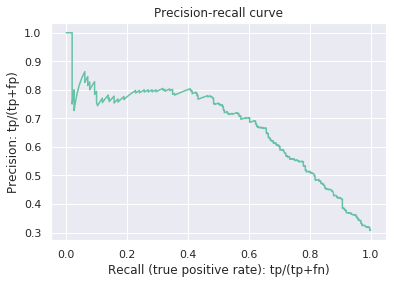

In [29]:
plot_precision_recall(y_test, y_score)

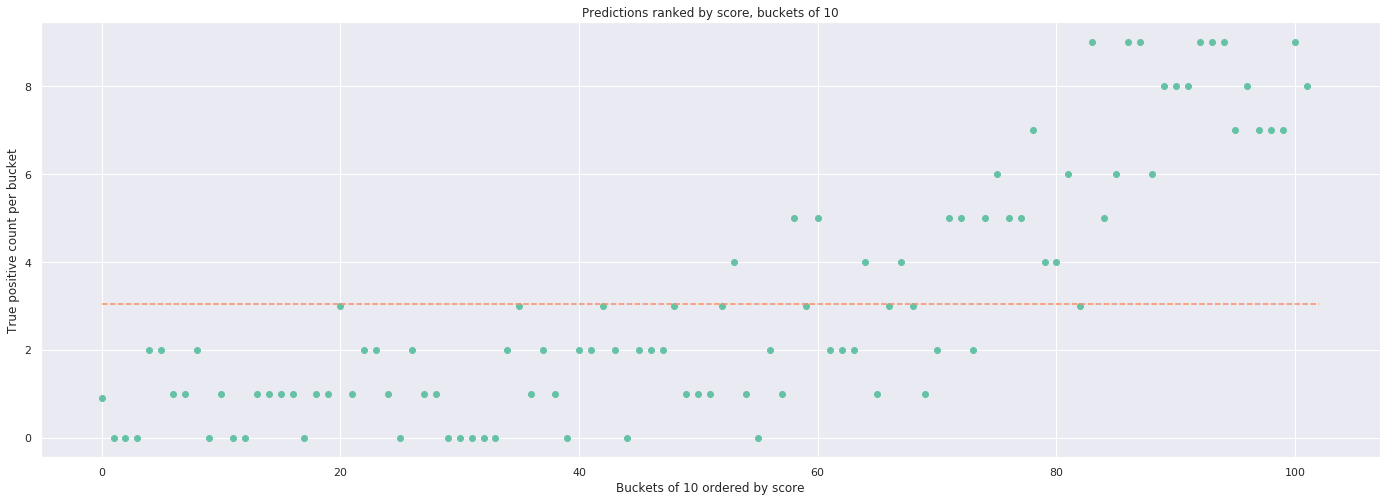

In [30]:
plt.figure(figsize=(24,8))
plot_bucket_counts(y_test, y_score, 10)

In [31]:
len(test_set)

1023

In [32]:
len(y_score)

1023

In [33]:
y_score

array([[0.15478724],
       [0.07010543],
       [0.6423662 ],
       ...,
       [0.11419476],
       [0.6569177 ],
       [0.21923961]], dtype=float32)

In [34]:
test_set['score'] = y_score

In [35]:
test_set.sample(5).T

,4445,321,1145,367,92
lead_id,12382566,9562709,13345618,12082631,8924878
form_data_id,1091676,471725,1203737,1046758,429992
lead_match_client_id,11,5795,6069,5861,5575
structured_campaign_name,K and B Transportation Inc. : otr (OTR 4) : PM...,Gardner Trucking : Northern California : PMC p...,Brady Trucking Inc : Tanker Company Driver : P...,Tri-National : Solo Team Company Drivers : PMC...,Crete Carrier Corporation : National : PMC p5 ...
company_nicename,K&B Transportation,Gardner Trucking,Brady Trucking,Tri-National Inc,Crete Carrier Corporation
full_name,Kenneth Morris,John Ross,Deandre Bagby,David reyes,Larry Plummer
hired,0,1,0,0,0
city,Memphis,Salida,Florissant,San Antonio,Portales
state,TN,CA,MO,TX,NM
zip,38109,95368,63031,78218,88130


In [36]:
test_set.to_excel('data/cig_test_scored.xlsx', index=False)